In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt

In [17]:
def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    #plt.savefig(figure_file)

In [14]:
class ActorCriticNetwork(nn.Module):
    def __init__(self, lr, input_dims, n_actions, fc1_dims=256, fc2_dims=256):
        super(ActorCriticNetwork, self).__init__()
        self.fc1 = nn.Linear(*input_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.pi = nn.Linear(fc2_dims, n_actions)
        self.v = nn.Linear(fc2_dims, 1)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        pi = self.pi(x)
        v = self.v(x)

        return (pi, v)

class Agent():
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions, 
                 gamma=0.99):
        self.gamma = gamma
        self.lr = lr
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.actor_critic = ActorCriticNetwork(lr, input_dims, n_actions, 
                                               fc1_dims, fc2_dims)
        self.log_prob = None

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor_critic.device)
        probabilities, _ = self.actor_critic.forward(state)
        probabilities = F.softmax(probabilities, dim=1)
        action_probs = T.distributions.Categorical(probabilities)
        action = action_probs.sample()
        log_prob = action_probs.log_prob(action)
        self.log_prob = log_prob

        return action.item()

    def learn(self, state, reward, state_, done):
        self.actor_critic.optimizer.zero_grad()

#         state = T.tensor([state], dtype=T.float).to(self.actor_critic.device)
#         state_ = T.tensor([state_], dtype=T.float).to(self.actor_critic.device)
#         reward = T.tensor(reward, dtype=T.float).to(self.actor_critic.device)

        state = T.tensor(np.array([state]), dtype=T.float).to(self.actor_critic.device)
        state_ = T.tensor(np.array([state_]), dtype=T.float).to(self.actor_critic.device)
        reward = T.tensor(reward, dtype=T.float).to(self.actor_critic.device)

        _, critic_value = self.actor_critic.forward(state)
        _, critic_value_ = self.actor_critic.forward(state_)

        delta = reward + self.gamma*critic_value_*(1-int(done)) - critic_value

        actor_loss = -self.log_prob*delta
        critic_loss = delta**2
        
        # sum to get around pytorch not having to go through graph twice
        (actor_loss + critic_loss).backward()
        self.actor_critic.optimizer.step()

In [ ]:
env = gym.make('LunarLander-v2')

# env = gym.make('CartPole-v1')
num_features = env.observation_space.shape[0]
num_actions = env.action_space.n

agent = Agent(gamma=0.99, lr=5e-6, input_dims=[num_features], n_actions=num_actions,
              fc1_dims=2048, fc2_dims=1536)
n_games = 3000

fname = 'ACTOR_CRITIC_' + 'lunar_lander_' + str(agent.fc1_dims) + \
        '_fc1_dims_' + str(agent.fc2_dims) + '_fc2_dims_lr' + str(agent.lr) +\
        '_' + str(n_games) + 'games'
figure_file = 'plots/' + fname + '.png'

scores = []
for i in range(n_games):
    done = False
    observation = env.reset()[0]
    score = 0
    iter = 0
    while not done and iter < 5000:
        action = agent.choose_action(observation)
        observation_, reward, trunc, done, info = env.step(action)
        score += reward
        agent.learn(observation, reward, observation_, done)
        observation = observation_
        iter += 1
    scores.append(score)

    if i % 100 == 0:
        avg_score = np.mean(scores[-100:])
        print('episode ', i, 'score %.1f' % score,
                'average score %.1f' % avg_score)

x = [i+1 for i in range(n_games)]
plot_learning_curve(x, scores, figure_file)

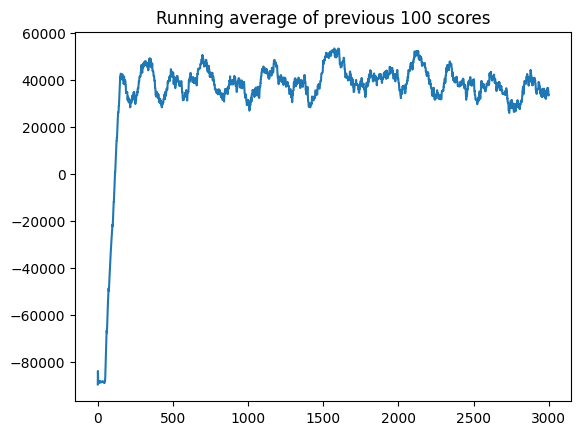

In [18]:
x = [i+1 for i in range(n_games)]
plot_learning_curve(x, scores, figure_file)

In [2]:
# approximates pi(a | s)
class PolicyModelTorch(torch.nn.Module):
  def __init__(self, D, K, hidden_layer_sizes):
    super().__init__()
    self.nn_model = torch.nn.Sequential()
    prev_dim = D
    for layer_num, layer_size in enumerate(hidden_layer_sizes):
        self.nn_model.add_module(f"fc_{layer_num}", torch.nn.Linear(prev_dim, layer_size))
        self.nn_model.add_module(f"act_{layer_num}", torch.nn.ReLU())
        prev_dim = layer_size
    self.nn_model.add_module("final_hidden_layer", torch.nn.Linear(prev_dim, K))
    self.nn_model.add_module("softmax", torch.nn.Softmax())

  def predict(self, X):
    return self.nn_model(X)

  def sample_action(self, X):
# return self.predict(X)
    with torch.no_grad():
        p = self.predict(X).numpy()
#         print("in sample action predict: ", p)
#         p /= p.sum()
       # return np.random.multinomial(len(p), p)
        p[-1] = 1 - np.sum(p[0:-1])
        return np.random.choice(len(p), p=p)


def policy_cost_function(preds, actions, advantages, K):
    # actions is a bunch of indices of (num_examples,) K is num_actions.
    # preds should be (num_examples, num_actions)
    # advantages are (num_examples,)
    # (num_examples, num_actions)
#     print("preds: ", preds)
    pred_action_scores = preds * torch.nn.functional.one_hot(actions, K)
#     print("pred_action_scores: ", pred_action_scores)
    # (num_examples,)
    selected_probs = torch.log(torch.sum(pred_action_scores, 1))
#     print("selected_probs: ", selected_probs)
    cost = -torch.sum(advantages * selected_probs)
    #cost = torch.sum(advantages * selected_probs)
    return cost

In [3]:
# approximates V(s)
class ValueModelTorch(torch.nn.Module):
  def __init__(self, D, hidden_layer_sizes):
    super().__init__()
    self.nn_model = torch.nn.Sequential()
    M1 = D
    for layer_num, M2 in enumerate(hidden_layer_sizes):
        self.nn_model.add_module(f"fc_{layer_num}", torch.nn.Linear(M1, M2))
#         self.nn_model.add_module(f"act_{layer_num}", torch.nn.Tanh())
        self.nn_model.add_module(f"act_{layer_num}", torch.nn.ReLU())
        M1 = M2
    self.nn_model.add_module("final_hidden_layer", torch.nn.Linear(M1, 1))
      
    #self.cost = torch.nn.MSELoss()

#     # calculate output and cost
#     Z = self.X
#     for layer in self.layers:
#       Z = layer.forward(Z)
#     Y_hat = tf.reshape(Z, [-1]) # the output
#     self.predict_op = Y_hat

#     cost = tf.reduce_sum(tf.square(self.Y - Y_hat))
#     self.train_op = tf.train.GradientDescentOptimizer(1e-4).minimize(cost)

#   def partial_fit(self, X, Y):
#     self.session.run(self.train_op, feed_dict={self.X: X, self.Y: Y})

  def predict(self, X):
    return self.nn_model(X)


  def cost_function(self, preds, actuals):
    return torch.sum((actuals - preds)**2)
    #return self.cost(preds, actuals)
    
   

In [9]:
def play_one_td(env, pmodel, vmodel, gamma, p_opt, v_opt):
  observation = env.reset()[0]
  done = False
  totalreward = 0
  iters = 0

  while not done and iters < 2000:
#   while not done and iters < 20:
    # if we reach 2000, just quit, don't want this going forever
    # the 200 limit seems a bit early
    
    
    prev_observation = observation
    prev_obs_tensor = torch.from_numpy(observation)
    action = pmodel.sample_action(prev_obs_tensor)
    observation, reward, done, trunc, info = env.step(action)

    # if done:
    #   reward = -200

    # update the models
#     with torch.no_grad():
    V_next = vmodel.predict(torch.from_numpy(observation))
    G = reward + gamma*V_next
    advantage = G - vmodel.predict(torch.from_numpy(prev_observation))
#     pmodel.partial_fit(prev_observation, action, advantage)
#     vmodel.partial_fit(prev_observation, G)
#     adv_copy = torch.tensor(advantage.detach().numpy())
    cost = policy_cost_function(pmodel.predict(torch.from_numpy(prev_observation)), 
                                torch.tensor([action]),
                                advantage, K)
    #print(cost, advantage)
    cost.backward()
    p_opt.step()
    
    G_copy = torch.tensor(G.detach().numpy())
    vcost = vmodel.cost_function(vmodel.predict(torch.from_numpy(prev_observation)), 
                              G_copy)
    vcost.backward()
    v_opt.step()
    p_opt.zero_grad()
    v_opt.zero_grad()

    if reward == 1: # if we changed the reward to -200
      totalreward += reward
    iters += 1

  return totalreward

In [10]:
env = gym.make('CartPole-v1')
D = env.observation_space.shape[0]
K = env.action_space.n
pmodel = PolicyModelTorch(D, K, [10, 5])
vmodel = ValueModelTorch(D, [10])

p_opt = torch.optim.Adagrad(pmodel.parameters(), lr=0.0001, lr_decay=0.99)
v_opt = torch.optim.Adagrad(vmodel.parameters(), lr=0.0001, lr_decay=0.99)
gamma = 0.99

total_reward = play_one_td(env, pmodel, vmodel, gamma, p_opt, v_opt)